<h4>Bing Cross Query Product Overlap Analysis</h4>

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_bing_df
from metrics import semantic_overlap
from plots import boxplot, heatmaps
from utility import top_n_semantic_products

In [2]:
random.seed(2025)

<h4>Dataset: Bing</h4>

In [3]:
bing_df = get_bing_df()
bing_df

,query,product,market_type,query_level,content,url,domain,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[The Best Phones We've Tested for 2025 | PCMag...,"[https://www.pcmag.com/picks/the-best-phones, ...","[pcmag.com, tomsguide.com, techradar.com, zdne...","[[Apple iPhone 17, Samsung Galaxy S25 Ultra, S..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,[Top Smartphones Under $1000 About UsTrendingR...,[https://www.analyticsinsight.net/gadgets/best...,"[analyticsinsight.net, techwiser.com, techspec...","[[Samsung Galaxy S25, iPhone 16 Pro, Google Pi..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,[9 Best Camera Phones Under $1000 for Amazing ...,[https://www.techwisehub.com/blog/best-camera-...,"[techwisehub.com, techwiser.com, amateurphotog...","[[Samsung Galaxy S25, iPhone 16, Google Pixel ..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[Best Phones Under $1000 (August 2025) - TechW...,[https://techwiser.com/best-phones-under-1000-...,"[techwiser.com, pcmag.com, techspecs.info, ana...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Plus..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[The Best Laptops We've Tested (September 2025...,"[https://www.pcmag.com/picks/the-best-laptops,...","[pcmag.com, nytimes.com, tomsguide.com, zdnet....","[[Dell 14 Plus (DB14250), Dell Precision 5690,..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[10 Best Laptops 2025 Under $1500: Complete Gu...,[https://gadgetsandall.com/10-best-laptops-202...,"[gadgetsandall.com, gizmodo.com, dockuniverse....","[[Apple MacBook Air 13″ (M4), ASUS ROG Strix G..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[10 Best Laptops Under $1500 for 2025: Perform...,[https://dockuniverse.com/best-laptops-for-150...,"[dockuniverse.com, pcmag.com, dockuniverse.com...",[[MSI Titan 18 HX Gaming Laptop (A14VIG-036US)...
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[10 Best Laptops Under $1500 for 2025: Perform...,[https://dockuniverse.com/best-laptops-for-150...,"[dockuniverse.com, pcmag.com, gizmodo.com, ofz...","[[MSI Titan 18 HX, ASUS Zenbook 14, MSI Titan ..."
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,[The Best Smartwatches We've Tested for 2025 |...,[https://www.pcmag.com/picks/the-best-smartwat...,"[pcmag.com, forbes.com, tomsguide.com, techrad...","[[Apple Watch Series 11, Samsung Galaxy Watch ..."
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,[Best budget smartwatches: 6 cheap but good op...,[https://www.wareable.com/smartwatches/best-ch...,"[wareable.com, tomsguide.com, pcmag.com, techr...","[[Amazfit Active 2, Huawei Watch Fit 3, Xiaomi..."


<h4>Cross-Query Mean Internal Product Overlap (Allpairs) – Definition & Implementation</h4>
For each query $q$, Bing returns three product lists 
$P_q^{\mathrm{B}} = \{p^{\mathrm{B}}_{q1}, p^{\mathrm{B}}_{q2}, ..., p^{\mathrm{B}}_{q10}\}$. 
To compare internal consistency across different queries, we compute the mean semantic overlap between all product lists from query $i$ and query $j$. Thus, the cross-query mean internal product overlap is defined as:
$$\mathrm{CQMIPO}[i,j] =
\frac{1}{|P_i^{\mathrm{B}}| \cdot |P_j^{\mathrm{B}}|}
\sum_{k=1}^{|P_i^{\mathrm{B}}|}
\sum_{l=1}^{|P_j^{\mathrm{B}}|}
\mathrm{overlap}_{semantic}(p^{\mathrm{B}}_{ik}, p^{\mathrm{B}}_{jl})$$

<p>
Since Bing produces ten product lists per query (versus ChatGPT’s three), we apply random subsampling without replacement to select three lists per query before computing CQMIPO.
This normalization ensures comparable dimensionality and fairness in the consistency analysis.
<p/>

In [4]:
def calc_cqmipo_allpairs(bing_df, filter_col = None):
    
    n = len(bing_df)
    cqmipo_matrix = np.full((n, n), 0, dtype = float)

    # ! added for comparing Bing to ChatGPT !
    product_lists = []
    for prods in bing_df["recommended_products"].tolist():
        product_lists.append(random.sample(prods, 3))
    
    # filter
    filter_values = bing_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                semantic_overlap(a, b)
                for a in product_lists[i]
                for b in product_lists[j]
            ]
            cqmipo = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmipo_matrix[i, j] = cqmipo
            cqmipo_matrix[j, i] = cqmipo
    
    return pd.DataFrame(cqmipo_matrix, index = bing_df["query"], columns = bing_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

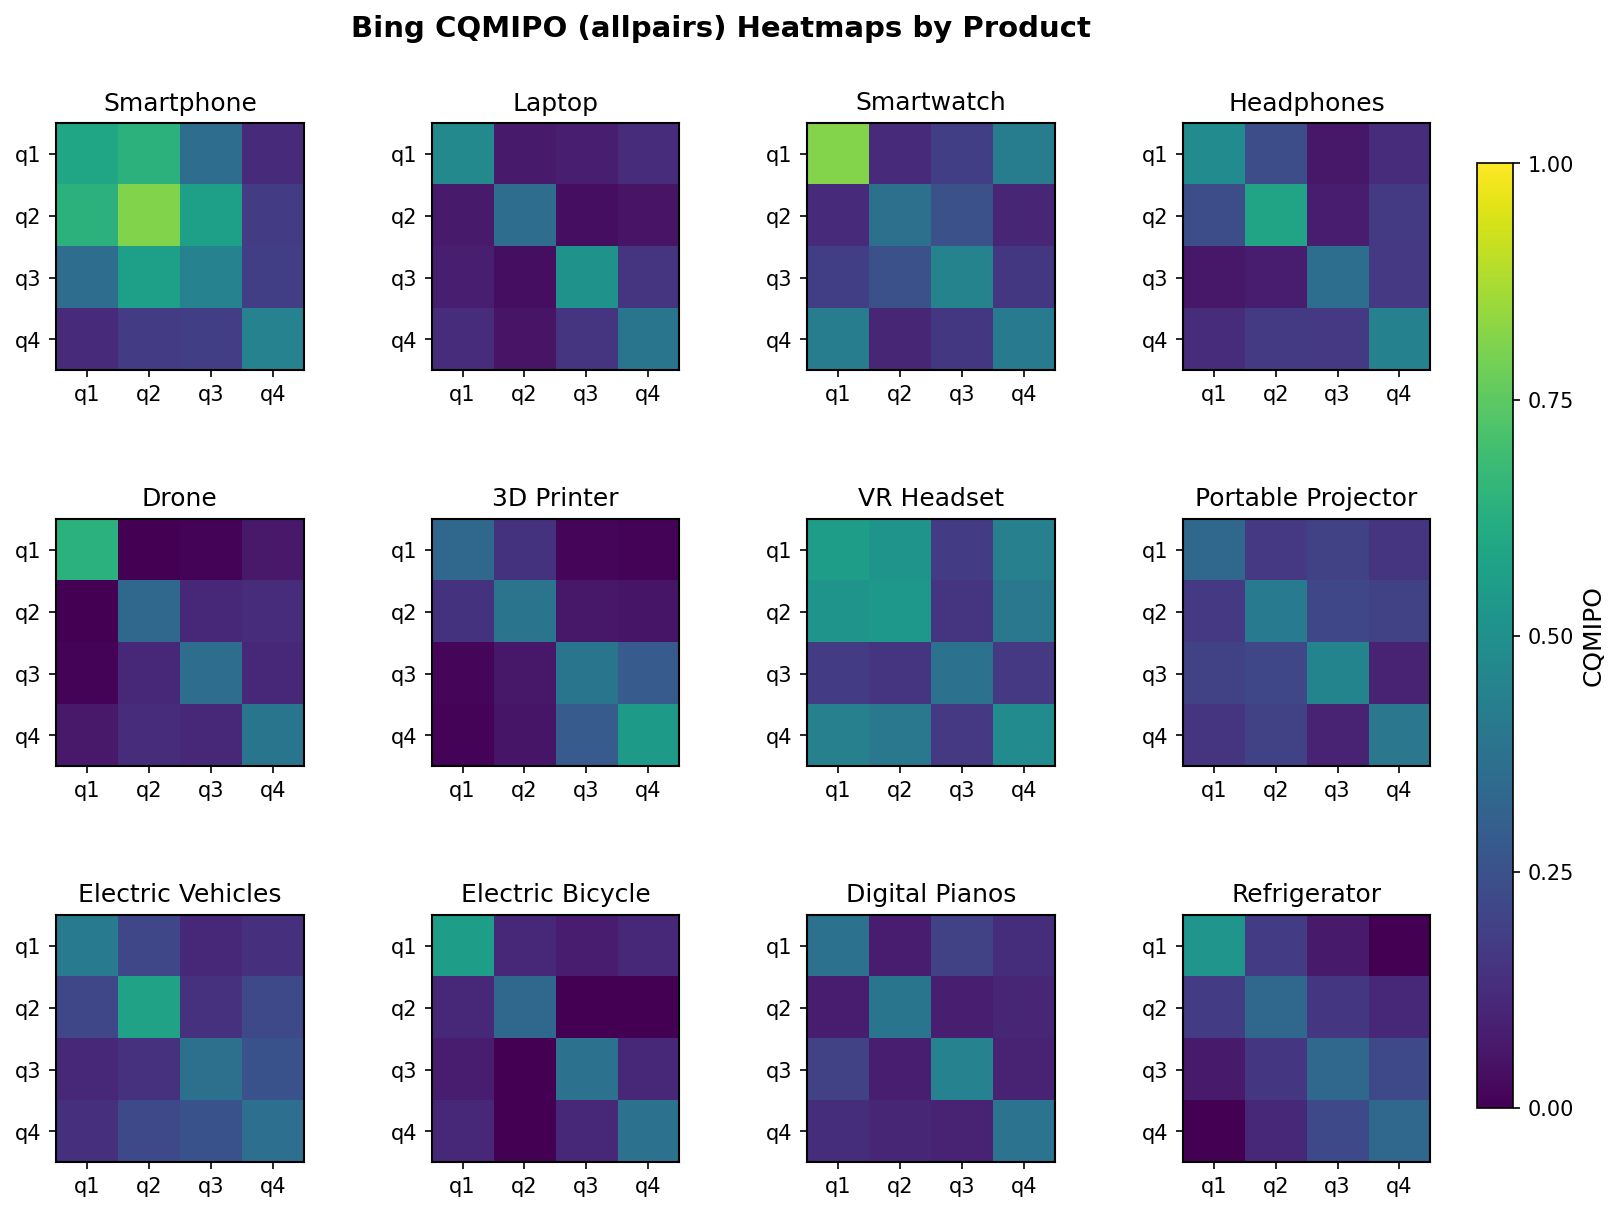

In [5]:
cqmipo_matrix_p = calc_cqmipo_allpairs(bing_df, filter_col = "product")
heatmaps(cqmipo_matrix_p, bing_df, filter_col = "product", title = "Bing CQMIPO (allpairs) Heatmaps by Product", colorbar_label = "CQMIPO")